In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from acquire import get_iris_data, get_telco_data, get_titanic_data
from prepare import tvt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier

# Exercises

In [2]:
titanic = get_titanic_data()

In [3]:
def dropped(titanic,columns={'sepal_length', 'petal_width'}):
    '''
    dropped will take the dataframe and remove any columns that are indicated,
    hopefully making the process faster
    '''
    titanic = titanic.drop(columns=columns)
    return titanic

def prep_titanic(titanic):
    '''
    prep_titanic will do all the cleaning we need of the database 'titanic_db'.
    It will:
    - drop unnecessary columns ('deck', 'embark_town', 'pclass')
    - fill in null values from columns (embarked' and 'age')
    - create dummy variables for the categorical columns 'sex', 'embarked', and 'class'
    - concatenate the previous dataframe to the new ones with dummy variables
    
    return: concatenated and cleaned dataframe 'titanic_db' as 'df'
    '''
    titanic = dropped(titanic,columns={'deck', 'embark_town', 'pclass', 'passenger_id'})
    round(titanic['age'].mean())
    top_embarked = titanic['embarked'].describe()['top']
    titanic['embarked'] = titanic['embarked'].fillna(value='S')
    titanic['age'] = titanic['age'].fillna(value='30').astype(int)
    titanic['sex_encoded'] = titanic['sex'].map({'male': 1, 'female': 0})
    titanic['embarked_encoded'] = titanic['embarked'].map({'S': 1, 'C': 0, 'Q':2})
    titanic['class_encoded'] = titanic['class'].map({'Second': 1, 'First': 0, 'Third':2})
    titanic = dropped(titanic,columns={'sex', 'embarked', 'class'})
    return titanic

## Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [4]:
titanic = prep_titanic(titanic)

In [5]:
titanic.dtypes

survived              int64
age                   int64
sibsp                 int64
parch                 int64
fare                float64
alone                 int64
sex_encoded           int64
embarked_encoded      int64
class_encoded         int64
dtype: object

In [6]:
titanic.head()

,survived,age,sibsp,parch,fare,alone,sex_encoded,embarked_encoded,class_encoded
0,0,22,1,0,7.2500,0,1,1,2
1,1,38,1,0,71.2833,0,0,0,0
2,1,26,0,0,7.9250,1,0,1,2
3,1,35,1,0,53.1000,0,0,1,0
4,0,35,0,0,8.0500,1,1,1,2


In [7]:
titanic['label'] = titanic['survived'] == 1

In [8]:
titanic['label'].value_counts()

label
False    549
True     342
Name: count, dtype: int64

In [9]:
# establishing baseline
titanic['baseline'] = titanic['survived'].value_counts().idxmax()
baseline_accuracy = (titanic.baseline == titanic.survived).mean()
baseline_accuracy

0.6161616161616161

In [10]:
tvt?

Signature: tvt(df, target)
Docstring:
tvt will take in a DataFrame and return train, validate, and test DataFrames; stratify on whatever you decide as the target in bracketed and quotations. tvt will also set a random state of 117.
For example: tvt(df,['survived']) will return the dataframe (in this case the titanic dataframe and stratify by 'survived').
return train, validate, test DataFrames.
File:      ~/codeup-data-science/Classification/classification-exercises/prepare.py
Type:      function

In [11]:
train, validate, test = tvt(titanic, ['survived'])
train.head()

,survived,age,sibsp,parch,fare,alone,sex_encoded,embarked_encoded,class_encoded,label,baseline
72,0,21,0,0,73.5000,1,1,1,1,False,0
682,0,20,0,0,9.2250,1,1,1,2,False,0
399,1,28,0,0,12.6500,1,0,1,1,True,0
756,0,28,0,0,7.7958,1,1,1,2,False,0
394,1,24,0,2,16.7000,0,0,1,2,True,0


Establishing Hypothesis:

H$_0$ = survival is independent of gender

H$_α$ = survival is dependent on gender

In [12]:
α = 0.05

In [13]:
gender_observed = pd.crosstab(titanic.survived, titanic.sex_encoded)
gender_observed

sex_encoded,0,1
survived,,
0,81,468
1,233,109


In [14]:
# stats testing to see possible drivers
chi2, p, degf, expected = stats.chi2_contingency(gender_observed)

print(f'chi^2 = {chi2:.4f}') 
print(f'p     = {p:.4f}')

if p < α:
    print('We reject the null hypothesis, it seems survival is dependent on gender.')
else:
    print('We fail to reject the null hypothesis, survival appears independent of gender.')

chi^2 = 260.7170
p     = 0.0000
We reject the null hypothesis, it seems survival is dependent on gender.


H$_0$ = survival is independent of age

H$_α$ = survival is dependent on age

In [15]:
age_observed = pd.crosstab(titanic.survived, titanic.age)
age_observed

age,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,70,71,74,80
survived,,,,,,,,,,,,,,,,,,,,,
0,0,2,7,1,3,0,1,2,2,6,...,3,2,0,2,3,1,3,2,1,0
1,7,5,3,5,7,4,2,1,2,2,...,0,2,2,0,0,0,0,0,0,1


In [16]:
# stats testing to see possible drivers
chi2, p, degf, expected = stats.chi2_contingency(age_observed)

print(f'chi^2 = {chi2:.4f}') 
print(f'p     = {p:.4f}')

if p < α:
    print('We reject the null hypothesis, it seems survival is dependent of embarked town.')
else:
    print('We fail to reject the null hypothesis, survival appears independent of embarked town.')

chi^2 = 103.6491
p     = 0.0056
We reject the null hypothesis, it seems survival is dependent of embarked town.


H$_0$ = survival is independent of fare

H$_α$ = survival is dependent on fare

In [17]:
fare_observed = pd.crosstab(titanic.survived, titanic.fare)
fare_observed

fare,0.0000,4.0125,5.0000,6.2375,6.4375,6.4500,6.4958,6.7500,6.8583,6.9500,...,153.4625,164.8667,211.3375,211.5000,221.7792,227.5250,247.5208,262.3750,263.0000,512.3292
survived,,,,,,,,,,,,,,,,,,,,,
0,14,1,1,1,1,1,2,2,1,1,...,1,0,0,1,1,1,1,0,2,0
1,1,0,0,0,0,0,0,0,0,0,...,2,2,3,0,0,3,1,2,2,3


In [18]:
# stats testing to see possible drivers
chi2, p, degf, expected = stats.chi2_contingency(fare_observed)

print(f'chi^2 = {chi2:.4f}') 
print(f'p     = {p:.4f}')

if p < α:
    print('We reject the null hypothesis, it seems survival is dependent of fare paid.')
else:
    print('We fail to reject the null hypothesis, survival appears independent of fare paid.')

chi^2 = 425.8084
p     = 0.0000
We reject the null hypothesis, it seems survival is dependent of fare paid.


In [19]:
train.head()

,survived,age,sibsp,parch,fare,alone,sex_encoded,embarked_encoded,class_encoded,label,baseline
72,0,21,0,0,73.5000,1,1,1,1,False,0
682,0,20,0,0,9.2250,1,1,1,2,False,0
399,1,28,0,0,12.6500,1,0,1,1,True,0
756,0,28,0,0,7.7958,1,1,1,2,False,0
394,1,24,0,2,16.7000,0,0,1,2,True,0


In [20]:
train.loc[:,'label'] = train['label'].apply(lambda x: 'Survived' if x else 'Survived Not')
validate.loc[:,'label'] = validate['label'].apply(lambda x: 'Survived' if x else 'Survived Not')
test.loc[:,'label'] = test['label'].apply(lambda x: 'Survived' if x else 'Survived Not')

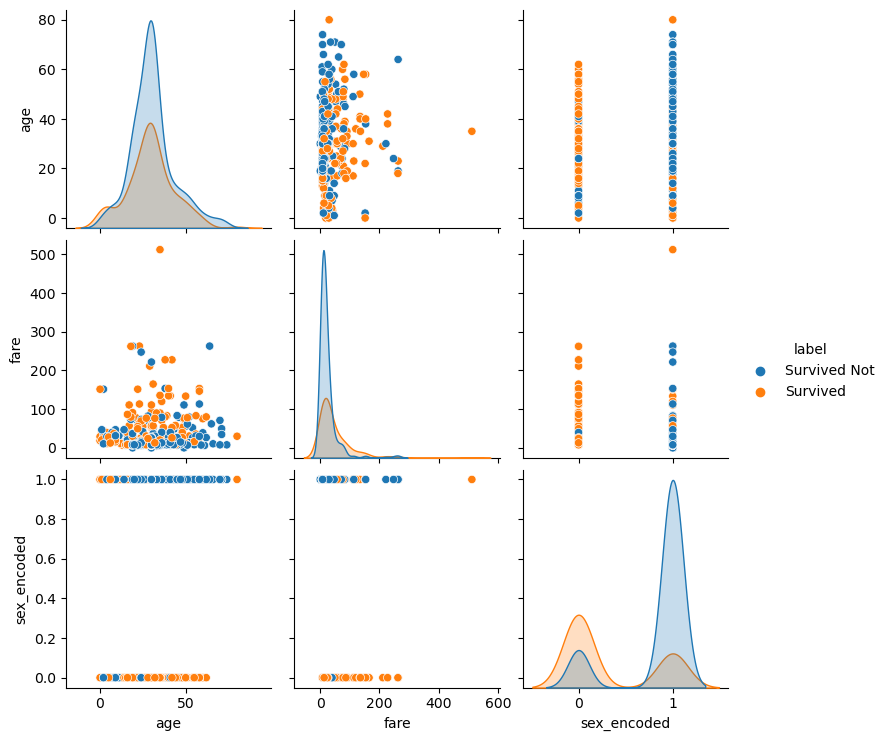

In [21]:
# I want to visualize what I believe are the main drivers of survival only
sns.pairplot(data=train.drop(columns={'survived', 'baseline', 'parch', 'class_encoded', 'alone', 'sibsp', 'embarked_encoded' }), hue='label')
plt.show()

In [22]:
train = train.drop(columns={'label','baseline'})
validate = validate.drop(columns={'label','baseline'})
test = test.drop(columns={'label','baseline'})

In [23]:
X_train = train.drop(columns=['survived'])
X_validate = validate.drop(columns=['survived'])
X_test = test.drop(columns=['survived'])
X_train.head()

,age,sibsp,parch,fare,alone,sex_encoded,embarked_encoded,class_encoded
72,21,0,0,73.5000,1,1,1,1
682,20,0,0,9.2250,1,1,1,2
399,28,0,0,12.6500,1,0,1,1
756,28,0,0,7.7958,1,1,1,2
394,24,0,2,16.7000,0,0,1,2


In [24]:
target = 'survived'
y_train = train[target]
y_validate = validate[target]
y_test = test[target]
y_train.head()

72     0
682    0
399    1
756    0
394    1
Name: survived, dtype: int64

In [25]:
X_train.isna().sum()

age                 0
sibsp               0
parch               0
fare                0
alone               0
sex_encoded         0
embarked_encoded    0
class_encoded       0
dtype: int64

In [26]:
rf?

Object `rf` not found.


In [27]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1)
rf

RandomForestClassifier(max_depth=10)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

## Evaluate your results using the model score, confusion matrix, and classification report.

In [29]:
y_pred = rf.predict(X_train)

In [30]:
#model score
rf.score(X_train, y_train)

0.9518072289156626

In [31]:
# confusion matrix
labels = sorted(y_train.unique())
neo = confusion_matrix(y_train, y_pred)
neo = pd.DataFrame(neo, 
                   index=[str(label)+ '_actual' for label in labels],
                   columns=[str(label)+ '_predicted' for label in labels]).T
neo

,0_actual,1_actual
0_predicted,301,18
1_predicted,6,173


In [32]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       307
           1       0.97      0.91      0.94       191

    accuracy                           0.95       498
   macro avg       0.96      0.94      0.95       498
weighted avg       0.95      0.95      0.95       498



## Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [33]:
neo

,0_actual,1_actual
0_predicted,301,18
1_predicted,6,173


In [34]:
def print_and_label(df):
    '''
    print_and_label will take a confusion matrix and by indexing, will store and calculate certain criteria for you.
    return: accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.
    '''
    TP = neo['0_actual']['0_predicted']
    FP = neo['1_actual']['0_predicted']
    FN = neo['0_actual']['1_predicted']
    TN = neo['1_actual']['1_predicted']
    neo_accuracy = (TP+TN)/(TP+FP+TN+FN)
    neo_precision = (TP)/(TP+FP)
    neo_recall = (TP)/(TP+FN)
    TPR = (TP)/(TP+FP)
    FPR = (FP)/(FP+TN)
    TNR = (TN)/(FP+TN)
    FNR = (FN)/(FN+TP)
    neo_support_0 = TP + FN
    neo_support_1 = FP + TN
    neo_f1 =  2 * ((neo_precision * neo_recall) / (neo_precision + neo_recall))
    return print(f'Accuracy: \n{neo_accuracy:2%}\n\nTrue Positive Rate: \n{TPR:2%}\n\nFalse Positive Rate: \n{FPR:2%}\n\nTrue Negative Rate: \n{TNR:2%}\n\nFalse Negative Rate: \n{FNR:2%}\n\nPrecision: \n{neo_precision:2%}\n\nRecall: \n{neo_recall:2%}\n\nF1 Score: \n{neo_f1:2%}\n\nSupport for Did Not Survive: \n{neo_support_0}\n\nSupport for Did Survive: \n{neo_support_1}')

In [35]:
print_and_label(neo)

Accuracy: 
95.180723%

True Positive Rate: 
94.357367%

False Positive Rate: 
9.424084%

True Negative Rate: 
90.575916%

False Negative Rate: 
1.954397%

Precision: 
94.357367%

Recall: 
98.045603%

F1 Score: 
96.166134%

Support for Did Not Survive: 
307

Support for Did Survive: 
191


## Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [36]:
rf2 = RandomForestClassifier(max_depth=5, min_samples_leaf=3)
rf2

RandomForestClassifier(max_depth=5, min_samples_leaf=3)

In [37]:
rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=3)

In [38]:
y_pred = rf2.predict(X_train)

In [39]:
#model score
rf2.score(X_train, y_train)

0.8775100401606426

In [40]:
# confusion matrix
labels = sorted(y_train.unique())
neo2 = confusion_matrix(y_train, y_pred)
neo2 = pd.DataFrame(neo2, 
                   index=[str(label)+ '_actual' for label in labels],
                   columns=[str(label)+ '_predicted' for label in labels]).T
neo2

,0_actual,1_actual
0_predicted,290,44
1_predicted,17,147


In [41]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       307
           1       0.90      0.77      0.83       191

    accuracy                           0.88       498
   macro avg       0.88      0.86      0.87       498
weighted avg       0.88      0.88      0.88       498



In [42]:
print_and_label(neo2)

Accuracy: 
95.180723%

True Positive Rate: 
94.357367%

False Positive Rate: 
9.424084%

True Negative Rate: 
90.575916%

False Negative Rate: 
1.954397%

Precision: 
94.357367%

Recall: 
98.045603%

F1 Score: 
96.166134%

Support for Did Not Survive: 
307

Support for Did Survive: 
191


## What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [68]:
model_1_train = rf.score(X_train, y_train)
model_1_validate = rf.score(X_validate, y_validate)
model_2_train = rf2.score(X_train, y_train)
model_2_validate = rf2.score(X_validate, y_validate)
print(f'Accuracy Scores:\n\nModel 1 Training Set:\n{model_1_train:2%}\n\n\
Model 1 Validation Set:\n{model_1_validate:2%}\n\nModel 2 Training Set:\n{model_2_train:2%}\n\n\
Model 2 Validation Set:\n{model_2_validate:2%}\n\nBaseline Accuracy:\n{baseline_accuracy:2%}\n\n')

Accuracy Scores:

Model 1 Training Set:
95.180723%

Model 1 Validation Set:
83.177570%

Model 2 Training Set:
87.751004%

Model 2 Validation Set:
84.579439%

Baseline Accuracy:
61.616162%




### Answer: The second model with the decreased depth performs worse in the training set but is much less overfit so it's a better accuracy to test.

# After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [44]:
rf3 = RandomForestClassifier(max_depth=7, min_samples_leaf=4)
rf3

RandomForestClassifier(max_depth=7, min_samples_leaf=4)

In [45]:
rf3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=4)

In [46]:
y_pred = rf3.predict(X_train)

In [47]:
rf3.score(X_train, y_train)

0.8674698795180723

In [48]:
# confusion matrix
labels = sorted(y_train.unique())
neo3 = confusion_matrix(y_train, y_pred)
neo3 = pd.DataFrame(neo3, 
                   index=[str(label)+ '_actual' for label in labels],
                   columns=[str(label)+ '_predicted' for label in labels]).T
neo3

,0_actual,1_actual
0_predicted,290,49
1_predicted,17,142


In [49]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       307
           1       0.89      0.74      0.81       191

    accuracy                           0.87       498
   macro avg       0.87      0.84      0.85       498
weighted avg       0.87      0.87      0.86       498



In [50]:
print_and_label(neo3)

Accuracy: 
95.180723%

True Positive Rate: 
94.357367%

False Positive Rate: 
9.424084%

True Negative Rate: 
90.575916%

False Negative Rate: 
1.954397%

Precision: 
94.357367%

Recall: 
98.045603%

F1 Score: 
96.166134%

Support for Did Not Survive: 
307

Support for Did Survive: 
191


Model 4

In [51]:
rf4 = RandomForestClassifier(max_depth=8, min_samples_leaf=6)
rf4

RandomForestClassifier(max_depth=8, min_samples_leaf=6)

In [52]:
rf4.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=6)

In [53]:
y_pred = rf4.predict(X_train)

In [54]:
rf4.score(X_train, y_train)

0.8634538152610441

In [55]:
# confusion matrix
labels = sorted(y_train.unique())
neo4 = confusion_matrix(y_train, y_pred)
neo4 = pd.DataFrame(neo4, 
                   index=[str(label)+ '_actual' for label in labels],
                   columns=[str(label)+ '_predicted' for label in labels]).T
neo4

,0_actual,1_actual
0_predicted,291,52
1_predicted,16,139


In [56]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       307
           1       0.90      0.73      0.80       191

    accuracy                           0.86       498
   macro avg       0.87      0.84      0.85       498
weighted avg       0.87      0.86      0.86       498



In [57]:
print_and_label(neo4)

Accuracy: 
95.180723%

True Positive Rate: 
94.357367%

False Positive Rate: 
9.424084%

True Negative Rate: 
90.575916%

False Negative Rate: 
1.954397%

Precision: 
94.357367%

Recall: 
98.045603%

F1 Score: 
96.166134%

Support for Did Not Survive: 
307

Support for Did Survive: 
191


Model 5

In [58]:
rf5 = RandomForestClassifier(max_depth=15, min_samples_leaf=10)
rf5

RandomForestClassifier(max_depth=15, min_samples_leaf=10)

In [59]:
rf5.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10)

In [60]:
y_pred = rf5.predict(X_train)

In [61]:
rf5.score(X_train, y_train)

0.8413654618473896

In [62]:
# confusion matrix
labels = sorted(y_train.unique())
neo5 = confusion_matrix(y_train, y_pred)
neo5 = pd.DataFrame(neo5, 
                   index=[str(label)+ '_actual' for label in labels],
                   columns=[str(label)+ '_predicted' for label in labels]).T
neo5

,0_actual,1_actual
0_predicted,288,60
1_predicted,19,131


In [63]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       307
           1       0.87      0.69      0.77       191

    accuracy                           0.84       498
   macro avg       0.85      0.81      0.82       498
weighted avg       0.85      0.84      0.84       498



In [64]:
print_and_label(neo5)

Accuracy: 
95.180723%

True Positive Rate: 
94.357367%

False Positive Rate: 
9.424084%

True Negative Rate: 
90.575916%

False Negative Rate: 
1.954397%

Precision: 
94.357367%

Recall: 
98.045603%

F1 Score: 
96.166134%

Support for Did Not Survive: 
307

Support for Did Survive: 
191


In [67]:
model_1_train = rf.score(X_train, y_train)
model_1_validate = rf.score(X_validate, y_validate)
model_1_overfit = model_1_train-model_1_validate

model_2_train = rf2.score(X_train, y_train)
model_2_validate = rf2.score(X_validate, y_validate)
model_2_overfit = model_2_train-model_2_validate

model_3_train = rf3.score(X_train, y_train)
model_3_validate = rf3.score(X_validate, y_validate)
model_3_overfit = model_3_train-model_3_validate

model_4_train = rf4.score(X_train, y_train)
model_4_validate = rf4.score(X_validate, y_validate)
model_4_overfit = model_4_train-model_4_validate

model_5_train = rf5.score(X_train, y_train)
model_5_validate = rf5.score(X_validate, y_validate)
model_5_overfit = model_5_train-model_5_validate

print(f'Baseline Accuracy:\n{baseline_accuracy:2%}\
\n\nAccuracy Scores:\
\n\nModel 1 Training Set:\n{model_1_train:2%}\n\nModel 1 Validation Set:\n{model_1_validate:2%}\n\nModel 1 Overfit:\n{model_1_overfit:2%}\
\n\nModel 2 Training Set:\n{model_2_train:2%}\n\nModel 2 Validation Set:\n{model_2_validate:2%}\n\nModel 2 Overfit:\n{model_2_overfit:2%}\
\n\nModel 3 Training Set:\n{model_3_train:2%}\n\nModel 3 Validation Set:\n{model_3_validate:2%}\n\nModel 3 Overfit:\n{model_3_overfit:2%}\
\n\nModel 4 Training Set:\n{model_4_train:2%}\n\nModel 4 Validation Set:\n{model_4_validate:2%}\n\nModel 4 Overfit:\n{model_4_overfit:2%}\
\n\nModel 5 Training Set:\n{model_5_train:2%}\n\nModel 5 Validation Set:\n{model_5_validate:2%}\n\nModel 5 Overfit:\n{model_5_overfit:2%}\
')

Baseline Accuracy:
61.616162%

Accuracy Scores:

Model 1 Training Set:
95.180723%

Model 1 Validation Set:
83.177570%

Model 1 Overfit:
12.003153%

Model 2 Training Set:
87.751004%

Model 2 Validation Set:
84.579439%

Model 2 Overfit:
3.171565%

Model 3 Training Set:
86.746988%

Model 3 Validation Set:
84.112150%

Model 3 Overfit:
2.634838%

Model 4 Training Set:
86.345382%

Model 4 Validation Set:
84.579439%

Model 4 Overfit:
1.765942%

Model 5 Training Set:
84.136546%

Model 5 Validation Set:
83.644860%

Model 5 Overfit:
0.491686%


### Answer: After creating 5 models, I found that model 5 (with a max_depth=15, and min_samples_leaf=10)had the least amount of overfit while still decimating the baseline by over 20%